In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
device = "cuda"

In [2]:
class config:
    model1 = "resnet18"
    model2 = "resnet18"
    batchsize = 32
    WEIGHT_DECAY = 0.01
    EPOCHS = 15
class path:
    maindir = "/kaggle/input/gsoclensing/dataset/train"
    valid = "/kaggle/input/gsoclensing/dataset/val"

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from tqdm import tqdm
import timm
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import time
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = np.load('/kaggle/input/gsoclensing/dataset/train/no/5955.npy')

In [6]:
data.shape

(1, 150, 150)

In [7]:
train_data = {}
for i in (range(len(os.listdir(path.maindir)))):
    for j in tqdm(os.listdir(os.path.join(path.maindir,os.listdir(path.maindir)[i]))):
        train_data[os.path.join(os.path.join(path.maindir,os.listdir(path.maindir)[i],j))]=i
        
valid_data = {}
for i in (range(len(os.listdir(path.valid)))):
    for j in tqdm(os.listdir(os.path.join(path.valid,os.listdir(path.valid)[i]))):
        valid_data[os.path.join(os.path.join(path.valid,os.listdir(path.valid)[i],j))]=i


100%|██████████| 2500/2500 [00:00<00:00, 2748.82it/s]


In [8]:
imgtrans = transforms.Compose([
    transforms.ToPILImage(mode='L'),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
]
)

In [9]:
class CustomDataset():
    def __init__(self,dictt,trans):
        self.trans = trans
        self.dic = dictt
    def __len__(self):
        return len(self.dic)
    def __getitem__(self,idx):
        keys = list(self.dic)[idx]
        data = np.load(keys)
        data = torch.tensor(data)
        data = self.trans(data)
        values = list(self.dic.values())[idx]
        return {
            "data":torch.tensor(data,dtype = torch.float32),
            "value":torch.tensor(values)
        }

    
            

In [10]:
custom = CustomDataset(train_data,imgtrans)


In [11]:
len(custom)

30000

In [12]:
custom[0]["data"]

tensor([[[-0.9686, -0.9843, -0.9843,  ..., -0.9765, -0.9922, -0.9843],
         [-0.9765, -0.9843, -0.9686,  ..., -0.9765, -0.9843, -0.9765],
         [-0.9843, -0.9765, -0.9686,  ..., -0.9765, -0.9843, -0.9922],
         ...,
         [-0.9686, -0.9922, -0.9765,  ..., -0.9843, -0.9843, -0.9843],
         [-0.9765, -0.9922, -0.9843,  ..., -0.9922, -0.9765, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9843, -0.9922, -0.9686]]])

In [13]:
def deltamat(shape):
    kk = np.zeros((shape,shape))
    for i in range(shape):
        for j in range(shape):
            kk[i][j] = (((i+1)**2)+((j+1)**2))**0.5
    return torch.tensor(kk,dtype = torch.float32)
positiontensor = deltamat(150)
positiontensor = positiontensor.unsqueeze(dim=0)
positiontensor=positiontensor.to("cuda")

In [14]:
class SimpleModel(nn.Module):
    def __init__(self,positionmat,batchsize = config.batchsize):
        super(SimpleModel,self).__init__()
        self.positionmat = positionmat
        self.batchsize = batchsize
        self.encoder = timm.create_model(
            config.model1,
            pretrained = True,
            drop_rate = 0.1
        )
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Linear(512,150*150,bias=True)
        
        self.doosramodel = timm.create_model(
            config.model2,
            pretrained = True,
            drop_rate = 0.1
        )
        self.doosramodel.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.doosramodel.fc = nn.Linear(in_features=512, out_features=3, bias=True)
    
    def lensingequation(self,angular,image):
        sourcedimage = image-angular
        return sourcedimage
    
    def forward(self,x):
        k = self.encoder(x)
        #print(k.shape)
        batch = k.shape[0]
        k = k.reshape(batch,1,150,150)
        angulardistort = k*self.positionmat
        #print(angulardistort.shape)
        sourced_image = self.lensingequation(x,angulardistort)
        twochannelimg = torch.cat((x,sourced_image),dim=1)
        features = self.doosramodel(twochannelimg)
        return features
        

In [15]:
#testing the model for a random tensor of shape (batch,channel,150,150)
simple = SimpleModel(positiontensor,32).to(device)
xx = torch.randn(size=(45,1,150,150)).to(device)

simple(xx)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

tensor([[ 0.1172, -0.2010,  0.0990],
        [ 0.3970, -0.0781,  0.0705],
        [ 0.1267, -0.1939,  0.1199],
        [ 0.0964,  0.0110,  0.2547],
        [-0.0134,  0.0302,  0.1272],
        [-0.1190, -0.0848,  0.0869],
        [ 0.0329, -0.1678,  0.2377],
        [ 0.0795, -0.0555,  0.2187],
        [ 0.2039,  0.0044, -0.0274],
        [ 0.0564, -0.0081,  0.2679],
        [ 0.0692,  0.0635,  0.1090],
        [ 0.1039, -0.2918,  0.2985],
        [-0.0311, -0.1393, -0.0187],
        [ 0.0685, -0.2222,  0.2756],
        [ 0.0746, -0.0730, -0.0169],
        [ 0.3572, -0.2356,  0.3781],
        [ 0.0125, -0.3226,  0.0673],
        [ 0.0382, -0.0697,  0.1668],
        [ 0.0542, -0.2101,  0.0417],
        [ 0.3588, -0.2178, -0.2003],
        [-0.0135, -0.1833,  0.3202],
        [-0.0492, -0.4274, -0.0427],
        [ 0.1024, -0.2142,  0.1581],
        [ 0.0584, -0.1223,  0.3715],
        [ 0.0851,  0.0066,  0.1118],
        [ 0.1077,  0.1371,  0.2461],
        [ 0.0773, -0.2252,  0.1586],
 

In [16]:
traindataset = CustomDataset(train_data,imgtrans)
validdataset  =CustomDataset(valid_data,imgtrans)

trainloader = DataLoader(traindataset,batch_size = 32,shuffle = True)
testloader = DataLoader(validdataset,batch_size = 32,shuffle = True)


In [17]:
from torch.optim.lr_scheduler import OneCycleLR


In [18]:
def trainer(model,trainloader,optimizer,criterion,device):
    model.train()
    iterationloss = 0
    counter = 0
    for data in tqdm(trainloader):
        message = data['data'].to(device)
        target = data['value'].to(device).squeeze()
        optimizer.zero_grad()
        out = model(message)
        loss = criterion(F.log_softmax(out, dim=1), target)
        loss.backward()
        optimizer.step()
        iterationloss+=loss.item()*message.shape[0]
        counter+=message.shape[0]
    return iterationloss/counter

In [19]:
def tester(model, testloader, criterion, device):
    model.eval()
    iteration_loss = 0
    counter = 0
    correct_predictions = 0
    y_true = []
    y_scores = []

    for data in tqdm(testloader):
        message = data['data'].to(device)
        target = data['value'].to(device).squeeze()
        
        with torch.no_grad():
            out = model(message)
            loss = criterion(F.log_softmax(out, dim=1), target)
            iteration_loss += loss.item() * message.shape[0]
            
            predicted_classes = torch.argmax(F.log_softmax(out, dim=1), dim=1)
            correct_predictions += (predicted_classes == target).sum().item()
            
            # Append the labels and probabilities to the list
            y_true.extend(target.cpu().numpy())
            y_scores.extend(F.softmax(out, dim=1).cpu().numpy())  # Probabilities for each class

        counter += message.shape[0]

    accuracy = correct_predictions / counter
    print("Accuracy:", accuracy)
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # calculating ROC AUC 
    roc_auc_scores = []
    false_positive_rate = dict()
    true_positive_rate = dict()
    for i in range(y_scores.shape[1]):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc_scores.append(roc_auc_score(y_true == i, y_scores[:, i]))

    # calcuating average ROC AUC across all the classes by one vs all method and taking mean of the 3 classes
    roc_score = np.mean(roc_auc_scores)
    print("ROC AUC Score:", roc_score)
    
    plt.figure(figsize=(8, 6))
    class_dict = {0:"no substructure",1:"spherical substructure",2:"vortex substructure"}
    for i in range(y_scores.shape[1]):
        plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'Class {class_dict[i]} (ROC AUC = {roc_auc_scores[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return iteration_loss / counter

In [20]:
meramodel = SimpleModel(positiontensor,config.batchsize)
meramodel.to(device)
optimizer = torch.optim.RAdam(meramodel.parameters(),lr = 0.005)
criterion = nn.CrossEntropyLoss()
scheduler = scheduler = OneCycleLR(
        optimizer,
        max_lr=0.01,
        epochs=config.EPOCHS,
        steps_per_epoch=938,
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100)

Epoch no. = 1
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:47<00:00,  4.90it/s]


Accuracy: 0.3449333333333333
ROC AUC Score: 0.5132067066666667


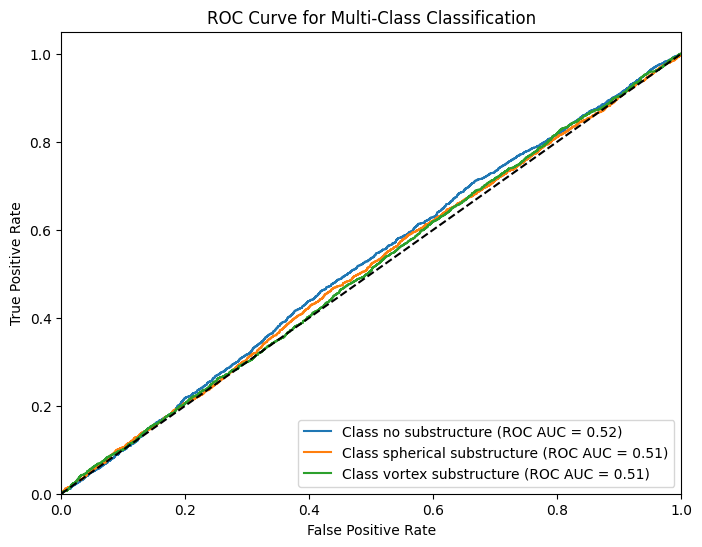

TrainLoss =  1.10112300974528   ValidationLoss =  1.0993004808425904
lr =  0.00040001448014674763
Best Model Saved
Epoch no. = 2
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.02it/s]


Accuracy: 0.35013333333333335
ROC AUC Score: 0.51444696


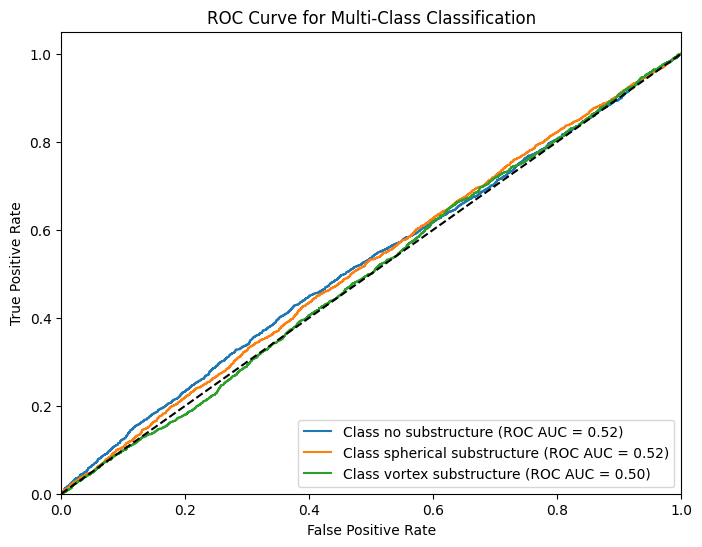

TrainLoss =  1.098842468770345   ValidationLoss =  1.0978857034047445
lr =  0.00040001444289943996
Best Model Saved
Epoch no. = 3
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.74it/s]


Accuracy: 0.34546666666666664
ROC AUC Score: 0.5101039866666667


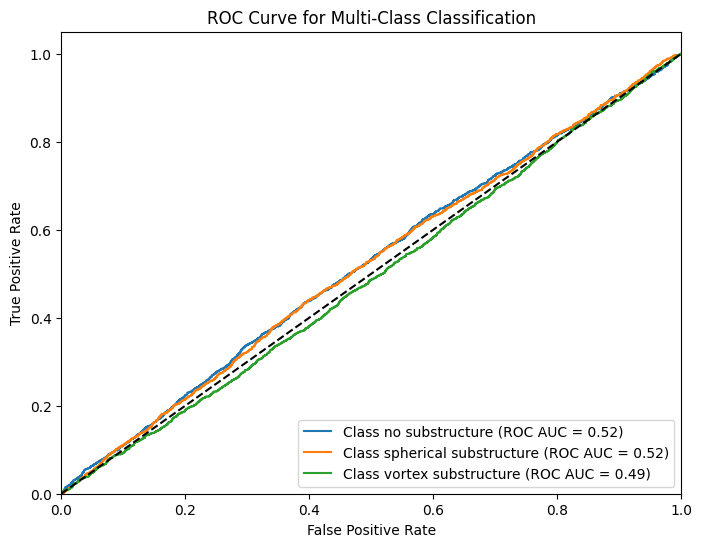

TrainLoss =  1.097901373799642   ValidationLoss =  1.0980277574539186
lr =  0.0004000144466371758
Epoch no. = 4
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.87it/s]


Accuracy: 0.35586666666666666
ROC AUC Score: 0.53214572


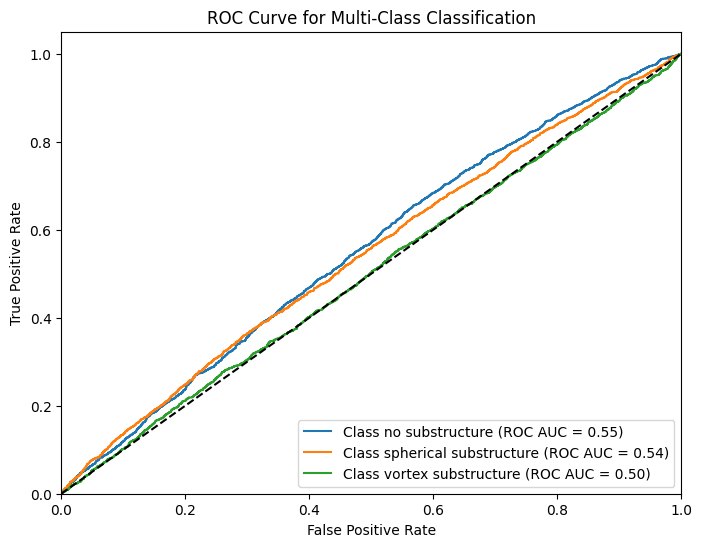

TrainLoss =  1.0961861306508383   ValidationLoss =  1.0963875141779582
lr =  0.0004000144035084148
Best Model Saved
Epoch no. = 5
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.08it/s]


Accuracy: 0.3721333333333333
ROC AUC Score: 0.5544856533333333


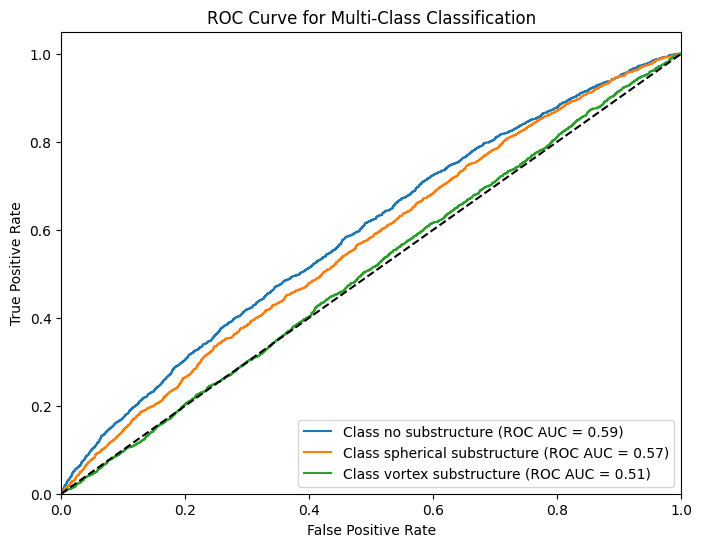

TrainLoss =  1.0932444235483805   ValidationLoss =  1.090856765683492
lr =  0.00040001425855744864
Best Model Saved
Epoch no. = 6
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.28it/s]


Accuracy: 0.46386666666666665
ROC AUC Score: 0.7522553066666666


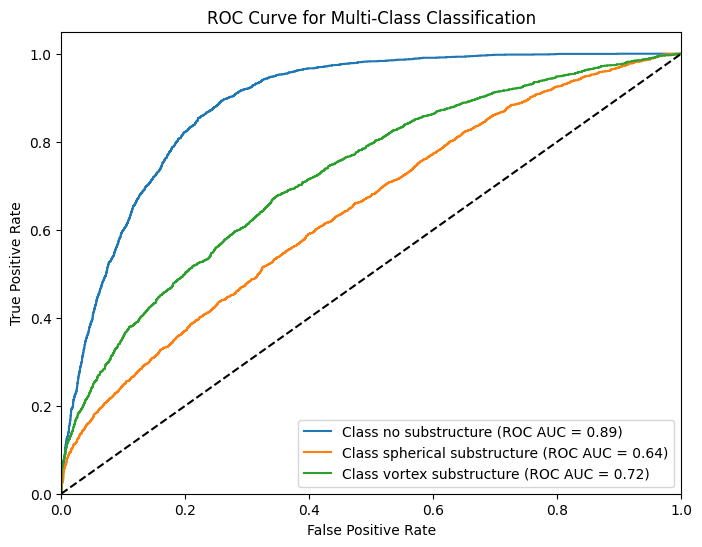

TrainLoss =  0.9413842308998108   ValidationLoss =  1.135630598449707
lr =  0.0004000154530526389
Epoch no. = 7
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.97it/s]


Accuracy: 0.6010666666666666
ROC AUC Score: 0.8507342533333334


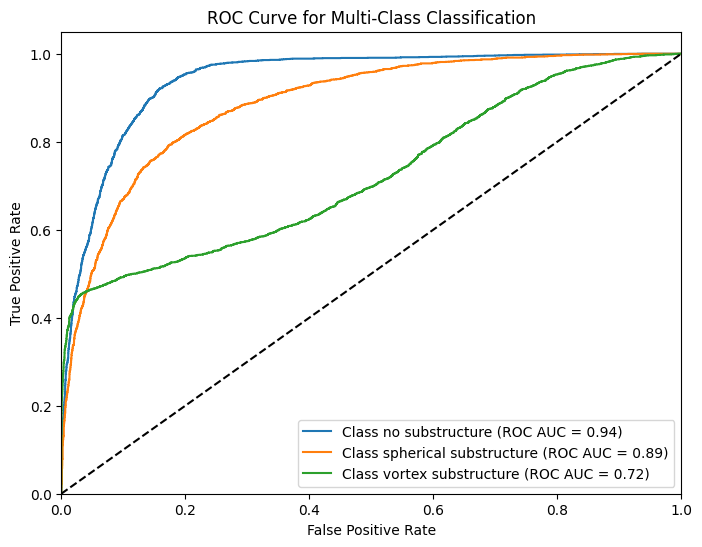

TrainLoss =  0.6451954991499583   ValidationLoss =  1.0199858845392864
lr =  0.0004000124660389938
Best Model Saved
Epoch no. = 8
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.00it/s]


Accuracy: 0.836
ROC AUC Score: 0.9492332933333333


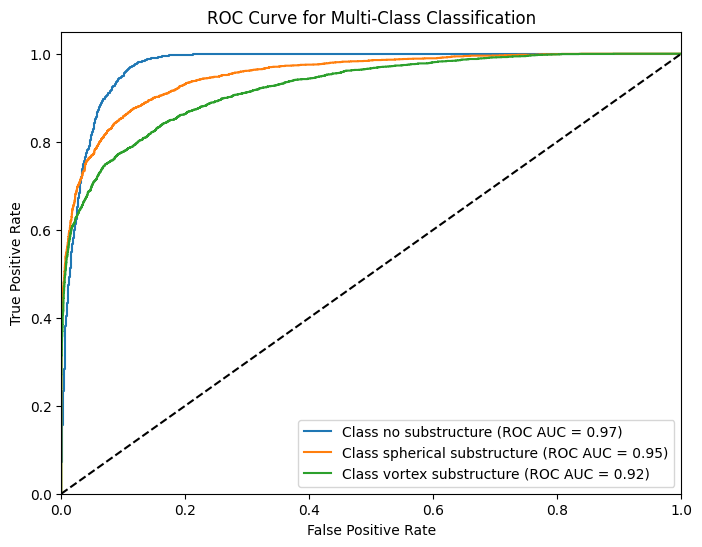

TrainLoss =  0.4519484932899475   ValidationLoss =  0.41307519598007203
lr =  0.00040000204455383284
Best Model Saved
Epoch no. = 9
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.54it/s]


Accuracy: 0.8494666666666667
ROC AUC Score: 0.95769584


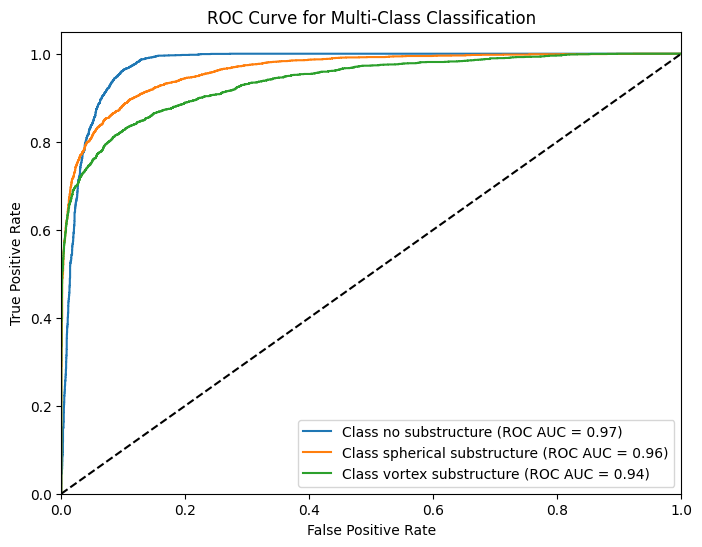

TrainLoss =  0.35821611718336743   ValidationLoss =  0.3842674988905589
lr =  0.00040000176932505037
Best Model Saved
Epoch no. = 10
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.45it/s]


Accuracy: 0.8650666666666667
ROC AUC Score: 0.9633566666666667


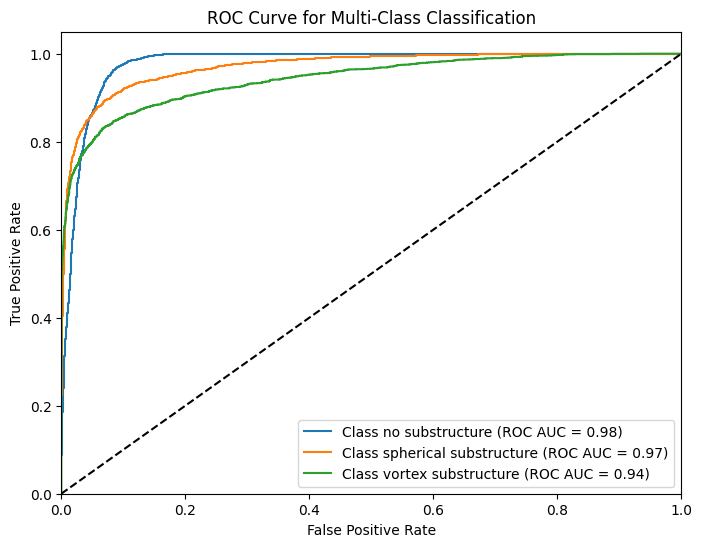

TrainLoss =  0.3064384211540222   ValidationLoss =  0.3657013026237488
lr =  0.00040000160248264936
Best Model Saved
Epoch no. = 11
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.01it/s]


Accuracy: 0.7762666666666667
ROC AUC Score: 0.9545555333333332


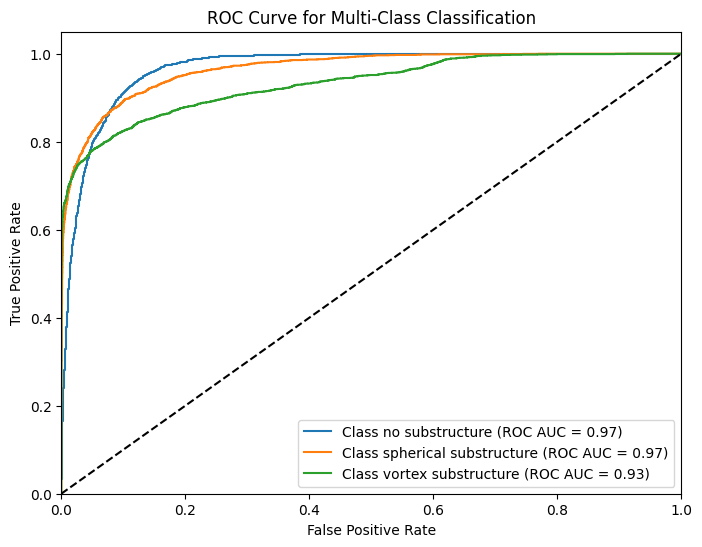

TrainLoss =  0.2633877578854561   ValidationLoss =  0.6241852378845215
lr =  0.0004000046683914158
Epoch no. = 12
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.82it/s]


Accuracy: 0.8925333333333333
ROC AUC Score: 0.97545576


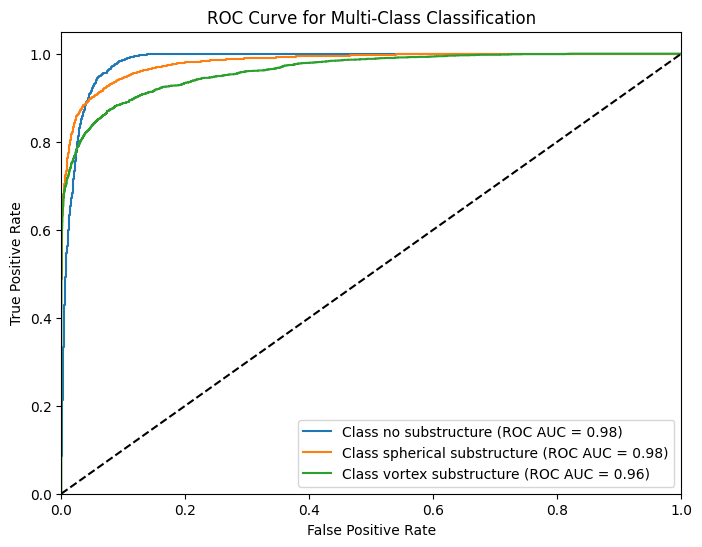

TrainLoss =  0.23379031950434048   ValidationLoss =  0.2832132293224335
lr =  0.00040000096109740237
Best Model Saved
Epoch no. = 13
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:16<00:00, 14.62it/s]


Accuracy: 0.8756
ROC AUC Score: 0.9696196133333332


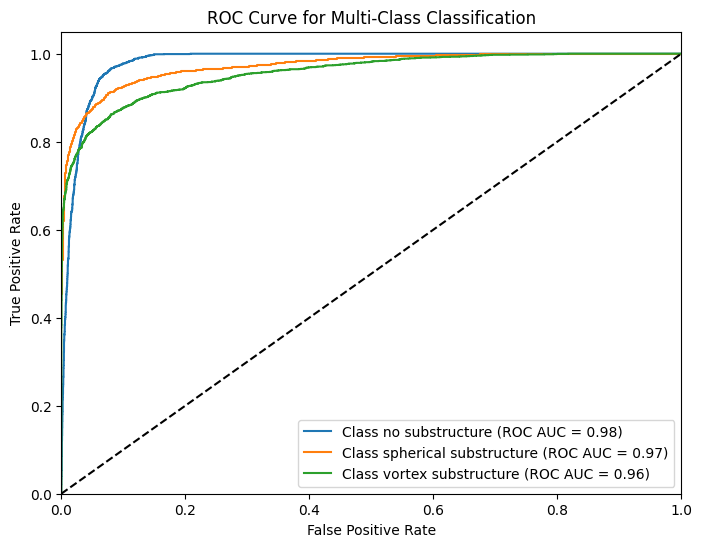

TrainLoss =  0.20753979155023894   ValidationLoss =  0.3790842032194138
lr =  0.0004000017219149398
Epoch no. = 14
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 15.22it/s]


Accuracy: 0.8808
ROC AUC Score: 0.9720988533333336


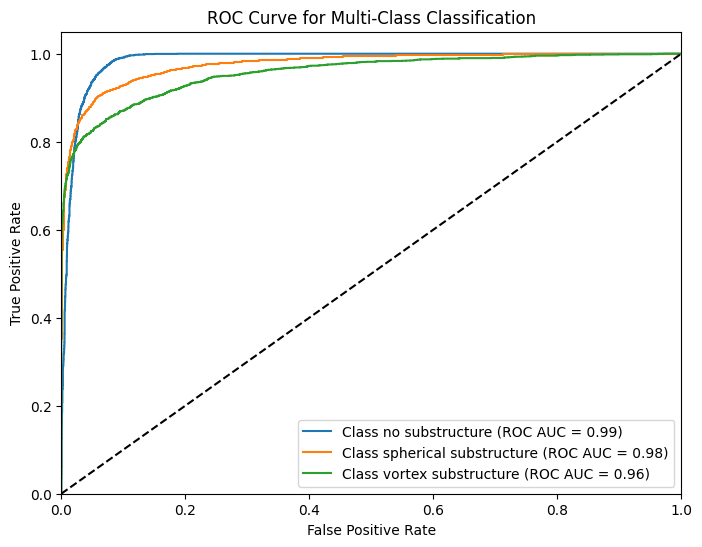

TrainLoss =  0.1900767315963904   ValidationLoss =  0.3609333785017331
lr =  0.00040000156096949187
Epoch no. = 15
--------------------------------------------------------------------------------


100%|██████████| 235/235 [00:15<00:00, 14.92it/s]


Accuracy: 0.7889333333333334
ROC AUC Score: 0.96232344


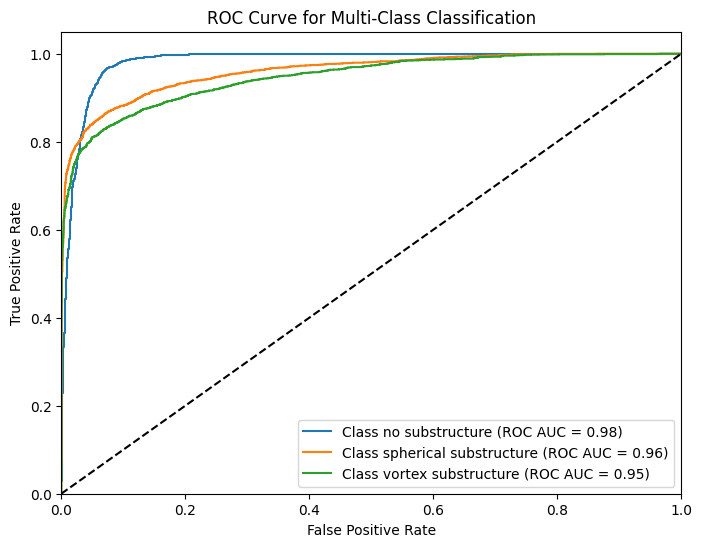

TrainLoss =  0.1701460815280676   ValidationLoss =  0.5342854625384013
lr =  0.0004000034204796367


In [21]:
trainloss =[]
valloss = []
bestloss = np.inf
for i in range(config.EPOCHS):
    print("Epoch no. =" ,i+1)
    print("-"*80)
    trainl = trainer(meramodel,trainloader,optimizer,criterion,device)
    vall = tester(meramodel,testloader,criterion,device)
    trainloss.append(trainl)
    valloss.append(vall)
    scheduler.step(vall)
    print("TrainLoss = ",trainl," ","ValidationLoss = ",vall)
    lr=scheduler.get_last_lr()[0]
    print("lr = ",lr)
    if bestloss>vall:
        bestloss = vall
        torch.save({
            'model':meramodel.state_dict(),
            'optimizer':optimizer.state_dict()},
        './Bestmodel.model'
        )
        print("Best Model Saved")
    print("="*80)